# Generative Adversarial Networks

In [159]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

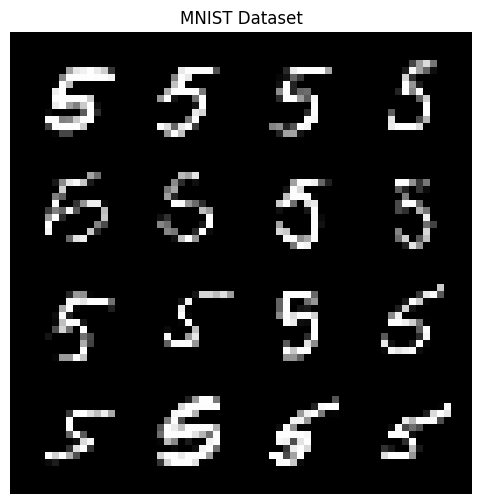

: 

In [176]:
def mnist_dataloader(batch_size=128, digit=5):
    '''
    Create a DataLoader for the MNIST dataset.
    Args:
        batch_size: int: The batch size to use.
    Returns:
        DataLoader: The DataLoader for the MNIST dataset.
    '''
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((14, 14), interpolation=0),
        transforms.Normalize((0.5,), (0.5,)),
        transforms.Lambda(lambda x: x.view(-1))
    ])
    dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    dataset.data = dataset.data[dataset.targets == digit]
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


def plot_dataset(X, verbose=True, **kwargs):
    '''
    Plot a 2D dataset.
    Args:
        X: torch.Tensor: The dataset to plot.
        bins: int: The number of bins to use for the histogram.
        ax: plt.Axes: The axes to plot on. If None, the current axes will be used.
        verbose: bool: Whether to show the axis labels.
        **kwargs: dict: Additional keyword arguments to pass to `ax.set`.
    '''
    # reshape the data to 14x14 images
    X = X.view(-1, 14, 14)
    # get 16 samples from the batch
    X = X[:16].unsqueeze(1)
    # make a grid of the images
    grid = make_grid(X, nrow=4, normalize=True)
    # plot the images
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.title(kwargs.get('title', ''))
    plt.show()


# Create the smiley face dataset and plot it.
dataset = mnist_dataloader()
X, _ = next(iter(dataset))
fig = plt.figure(figsize=(6, 6))
plot_dataset(X, title='MNIST Dataset')

In [170]:
class Block(nn.Module):
    def __init__(self, in_features, out_features, normalize=True):
        '''
        Create a block of an MLP.
        Args:
            in_features: int: The number of input features.
            out_features: int: The number of output features.
            normalize: bool: Whether to apply batch normalization.
        '''
        super().__init__()
        layers = [nn.Linear(in_features, out_features)]
        if normalize:
            layers.append(nn.BatchNorm1d(out_features, 0.8))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.block = nn.Sequential(*layers)

    def forward(self, X):
        '''
        Forward pass of the model.
        Args:
            X: torch.Tensor: The input features.
        '''
        return self.block(X)

class Generator(nn.Module):
    def __init__(self, image_size=14, latent_dim=8):
        '''
        Create an MLP to generate samples from a latent space.
        Args:
            n_features: int: The number of input and output features.
            latent_dim: int: The dimensionality of the latent space.
        '''
        super().__init__()

        
        self.model = nn.Sequential(
            Block(latent_dim, latent_dim*2, normalize=False),
            Block(latent_dim*2, latent_dim*4),
            Block(latent_dim*4, latent_dim*8),
            Block(latent_dim*8, latent_dim*16),
            nn.Linear(latent_dim*16, image_size*image_size),
            nn.Tanh()
        )


    def forward(self, X):
        '''
        Forward pass of the model.
        Args:
            X: torch.Tensor: The input features.
        '''
        X = self.model(X)
        return X
    
class Discriminator(nn.Module):
    def __init__(self, image_size=14):
        '''
        Create an MLP to discriminate between real and generated samples.
        Args:
            n_features: int: The number of input and output features.
            latent_dim: int: The dimensionality of the latent space.
        '''
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(image_size*image_size, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )


    def forward(self, X):
        '''
        Forward pass of the model.
        Args:
            X: torch.Tensor: The input features.
        '''
        X = self.model(X)
        return X

In [173]:

def training_loop(generator, discriminator, dataloader, lr, latent_dim, n_steps=5000):
    '''
    Train a model using the forward diffusion model.
    Args:
        model: nn.Module: The model to train.
        forward: ForwardDiffusion: The forward diffusion model to use.
        n_steps: int: The number of training steps to take.
        batch_size: int: The number of samples in each batch.
        lr: float: The learning rate to use.
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    loss_fn = nn.BCELoss()
    
    generator.to(device)
    discriminator.to(device)
    step_bar = trange(n_steps, desc='Steps')

    for step in step_bar:

        # Train the generator
        optimizer_g.zero_grad()

        batch = next(iter(dataloader))[0].to(device)
        noise = torch.randn(batch.shape[0], latent_dim).to(device)
        generated = generator(noise)
        fake = discriminator(generated)
        loss_g = loss_fn(fake, torch.ones_like(fake))
        loss_g.backward()
        optimizer_g.step()

        # Train the discriminator
        optimizer_d.zero_grad()
        real = discriminator(batch)
        fake = discriminator(generated.detach())
        loss_d = (loss_fn(real, torch.ones_like(real)) + loss_fn(fake, torch.zeros_like(fake)))/2
        loss_d.backward()
        optimizer_d.step()

        if step % 100 == 0:
            step_bar.set_postfix({'loss_g': loss_g.item(), 'loss_d': loss_d.item()})
            generator.train()
            discriminator.train()

latent_dim = 8
generator = Generator(image_size=14, latent_dim=latent_dim)
discriminator = Discriminator(image_size=14)
training_loop(generator, discriminator, dataset, lr=1e-3, latent_dim=latent_dim)

Steps: 100%|██████████| 5000/5000 [02:13<00:00, 37.51it/s, loss_g=1.06, loss_d=0.437] 


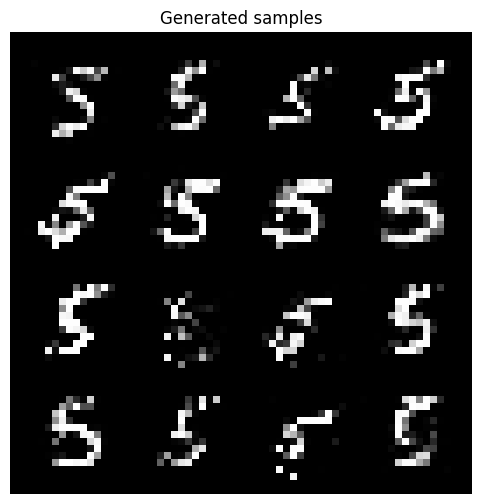

In [175]:
@torch.no_grad()
def sample(generator, n_samples, latent_dim=8, device='cpu'):
    '''
    Sample from the generator.
    Args:
        generator: nn.Module: The generator model.
        n_samples: int: The number of samples to generate.
    '''
    generator.to(device).eval()
    noise = torch.randn(n_samples, latent_dim).to(device)
    generated = generator(noise)

    plot_dataset(generated, title='Generated samples')
    plt.show()
# Sample from the generator and plot the results.
fig = plt.figure(figsize=(6, 6))
sample(generator, n_samples=24, latent_dim=latent_dim)